<a href="https://colab.research.google.com/github/davideliseo/ia-icci-g2/blob/main/lab-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 1 - Reconocimiento de imágenes

- **Grupo**: 2
- **Integrantes**: Lukas Poffal Munita y David Uribe Fuentes

Desarrollo de un modelo de clasificación de imágenes en dígitos del 0 al 9.

La totalidad del notebook es no-interactiva, exceptuando la última celda, que corresponde al frontend de la aplicación. Por lo tanto, el notebook se debe ejecutar de inicio a final, sin mayores retrasos (a menos que la construcción del modelo se configure en `ModelMode.TRAIN`, ya que de esta manera se procedería a entrenar nuevamente el modelo).

## 1. Modelo (backend)

### 1.1.a. Configuración del entorno

In [1]:
# NumPy es una librería para computación numérica en Python, que proporciona 
# soporte para arreglos, matrices y diversas operaciones matemáticas.
import numpy as np

# Esta línea importa la librería Keras desde TensorFlow. Keras es una API de 
# redes neuronales de alto nivel escrita en Python, que se ejecuta sobre
# TensorFlow. Keras se utiliza para construir y entrenar modelos de redes neuronales.                     
import tensorflow as tf

# Keras proporciona diversas capas predefinidas, como capas densas,
# convolucionales, recurrentes, de agrupamiento, de normalización, entre otras. 
# Al importar el módulo de capas, se pueden utilizar estas capas para construir
# modelos de redes neuronales en TensorFlow.
from tensorflow.keras import layers, Model

# Monta la unidad de Google Drive en Google Colab y establecer la ubicación
# de la carpeta que se utilizará para trabajar en el notebook.
from google.colab import drive                            
drive.mount("/content/drive", force_remount=True)

PATH = "/content/drive/Shareddrives/G2 - IA/Lab 1"    # Ruta base de la aplicación.
WEIGHTS_PATH = f"{PATH}/out/checkpoint/weights"       # Ruta de los pesos del modelo.
LOG_PATH = f"{PATH}/out/log.csv"                      # Ruta del log de entrenamiento.

Mounted at /content/drive


### 1.1.b. Parámetros del modelo

In [ ]:
# Parámetros del modelo.
NUM_CLASSES = 10                  # Cantidad de dígitos distinguibles.
IMAGE_SHAPE = (28, 28)            # Imágenes de 28x28.
INPUT_SHAPE = (*IMAGE_SHAPE, 1)   # La entrada también es de 28x28 más 1 canal de color.

### 1.2. Carga de datos

In [2]:
# Carga los datos a partir de la base de datos MNIST.
def load_data():
  return tf.keras.datasets.mnist.load_data()

### 1.3. Preprocesamiento de datos

In [3]:
def preprocess_data(data):
  # Divide los datos entre los conjuntos de entrenamiento y de prueba.
  (x_train, y_train), (x_test, y_test) = data

  # Escala imágenes al rango [0, 1].
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Agrega una dimensión para asegurar que tengan la forma de INPUT_SHAPE.
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  # Convierte los vectores en matrices de tipo categóricas.
  y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
  y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)
  return (x_train, y_train), (x_test, y_test)

### 1.4. Definición del modelo

In [4]:
def assemble_model():
  # Define un modelo de red neuronal convolucional (CNN).
  model = tf.keras.Sequential([
      tf.keras.Input(shape=INPUT_SHAPE),
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dropout(0.5),
      layers.Dense(NUM_CLASSES, activation="softmax"),
  ])

  # Configura el modelo para su entrenamiento.
  model.compile(
      loss="categorical_crossentropy", 
      optimizer="adam", 
      metrics=["accuracy"]
  )

  return model

### 1.5.a. Entrenamiento del modelo


In [5]:
def train_model(model: Model, x_train, y_train) -> Model:
  # Se determina el tamaño del lote utilizado para entrenar el modelo.
  batch_size = 128

  # Se determina el número de épocas, o iteraciones completas a través de todo
  # el conjunto de datos de entrenamiento, que se utilizarán para entrenar el modelo.
  epochs = 15

  # Define un objeto de registro que registra la información de la precisión
  # y la pérdida del modelo durante el entrenamiento.
  logger = tf.keras.callbacks.CSVLogger(LOG_PATH, append=False)

  # Callback que guarda los pesos del modelo después de cada época.
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath=WEIGHTS_PATH,
      save_weights_only=True,
      save_best_only=True,
      save_freq="epoch",
      monitor="val_accuracy",
      mode="auto",
      verbose=1,
  )

  # Entrena el modelo utilizando los datos de entrenamiento.
  model.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.1,
      callbacks=[logger, checkpoint]
  )

  return model

### 1.5.b. Restauración de pesos

In [6]:
# Carga de los pesos exportados en el entrenamiento del modelo.
def load_model(model: Model) -> Model:
    model.load_weights(WEIGHTS_PATH)
    return model

### 1.6. Normalización de imágenes

In [7]:
from PIL import Image
import io

# Normalización de la imagen.
def normalize_img(img: bytes):
  img = Image.open(io.BytesIO(img))               # Convierte una imagen de bytes a formato PIL.
  img = img.convert("L")                          # Convierte la imagen en escala de grises.
  img = img.resize(IMAGE_SHAPE)                   # Redimensiona la imagen a 28x28.
  img_array = np.asarray(img) / 255.0             # Escala los píxeles de la imagen al rango [0, 1].
  img_array = np.expand_dims(img_array, axis=0)   # Agrega una dimensión al inicio de cada píxel.
  return img_array

### 1.7. Clasificación de dígitos

In [8]:
# Clasificación de dígitos.
def classify_digit(model: Model, img: bytes):
  img_array = normalize_img(img)

  # Arreglo de n=10, donde cada entrada i corresponde a la probabilidad de que 
  # el dígito sea el número i. 
  predictions = model.predict(img_array, verbose=0)

  digit = np.argmax(predictions)  # Índice del valor con la probabilidad más alta.
  score = np.max(predictions)     # Valor con la probabilidad más alta.
  return digit, score

### 1.8. Construcción del modelo

In [9]:
from enum import unique, Enum
import os

@unique
class ModelMode(str, Enum):
    AUTO = "auto"
    LOAD = "load"
    TRAIN = "train"

# Se define el modelo.
model = assemble_model()

# Técnicamente, si solo se carga el modelo, no es necesario cargar y 
# preprocesar los datos de entrenamiento, ya que no se necesita entrenamiento 
# en primer lugar. Se cargan de todas formas para evaluar el modelo más adelante.
(x_train, y_train), (x_test, y_test) = preprocess_data(load_data())

# Branching lógico de la construcción del modelo, dependiendo si se desea 
# entrenar, cargar o la que sea necesaria.
mode = ModelMode.LOAD
if mode == ModelMode.AUTO:
    if os.path.isfile(WEIGHTS_PATH):
        mode = ModelMode.LOAD 
    else: 
        mode = ModelMode.TRAIN

if mode == ModelMode.LOAD:
    model = load_model(model)

elif mode == ModelMode.TRAIN:
    model = train_model(model, x_train, y_train)

### 1.9. Validación de los resultados

In [20]:
# Tolerancia de aceptación de una imagen como dígito. Predicciones con una
# puntuación mayor o igual a esta tolerancia SON considerados como dígitos.
# Predicciones con una puntuación menor NO SON considerados como dígitos.
TOLERANCE = 0.7

# Valida el rendimiento del modelo utilizando un set de 10 imágenes de prueba.
for i in range(0, 10):
  with open(f"{PATH}/tests/passing/{i}.png", "rb") as f:
    digit, score = classify_digit(model, f.read())
    assert digit == i and score >= TOLERANCE, \
      (f"La imagen ({digit}) no corresponde con el dígito esperado ({i}) "
       f"(con una tolerancia del {TOLERANCE}).")
    print(f"PASSED: {(digit, score)}")

PASSED: (0, 0.9999474)
PASSED: (1, 0.99993193)
PASSED: (2, 0.99999404)
PASSED: (3, 0.9999999)
PASSED: (4, 0.9999949)
PASSED: (5, 0.9999999)
PASSED: (6, 0.99989295)
PASSED: (7, 0.99999964)
PASSED: (8, 0.9999993)
PASSED: (9, 0.998978)


### 1.8. Análisis del modelo

Test loss: 0.025668218731880188
Test accuracy: 0.9916999936103821
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                        

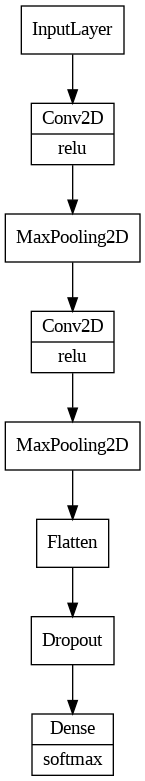

In [21]:
# Se valida el modelo utilizando el conjunto de datos de prueba-
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Imprime un resumen del modelo, que muestra la arquitectura de la red, el 
# número de parámetros entrenables y la forma de los datos en cada capa
print(model.summary())

# Muestra un diagrama de la arquitectura de la red.
from keras.utils import plot_model
plot_model(model, show_layer_names=False, show_layer_activations=True)

Gráfico de precisión:


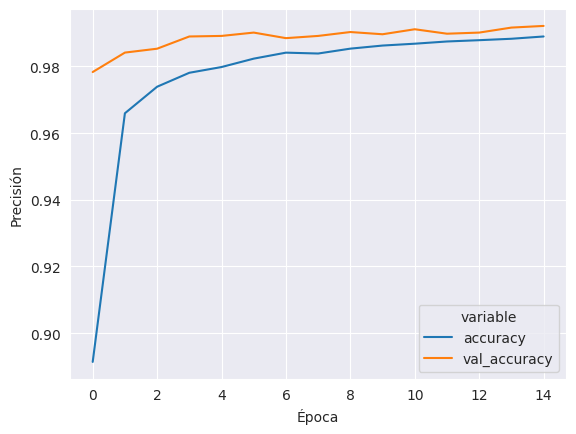


Gráfico de pérdida:


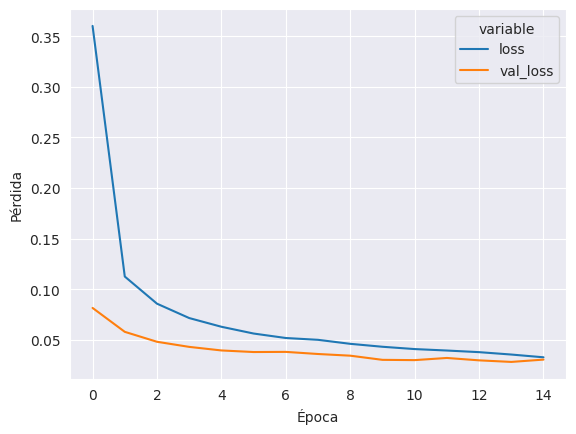

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_train_performance(by: str, label: str):
  # Lee el log de entrenamiento.
  df = pd.read_csv(LOG_PATH, usecols=['epoch', by, f"val_{by}"])
  sns.set_style("darkgrid")

  # Crea un gráfico de línea.
  sns.lineplot(x='epoch', y='value', hue='variable', data=pd.melt(df, ['epoch']))

  # Define las etiquetas de los ejes x e y.
  plt.xlabel('Época')
  plt.ylabel(label)

  # Muestra el gráfico.
  plt.show()

print("Gráfico de precisión:")
plot_train_performance("accuracy", "Precisión")

print("\nGráfico de pérdida:")
plot_train_performance("loss", "Pérdida")

## 2. Frontend

### 2.1. Comunicación con el modelo

In [23]:
from google.colab import output
import IPython as ipy
import base64
import traceback

# Callback que se comunica desde el interior del frontend (vía 
# `google.colab.kernel.invokeFunction`), para recibir la imagen cargada y
# ejecutar el modelo sobre ella.
def classify_digit_callback(img):
  try:
    _, img = img.split(",", 1)        # Elimina el prefijo "data:(...)"
    decoded = base64.b64decode(img)   # Decodifica la imagen desde base64 a un arreglo de byes.

    digit, score = classify_digit(model, decoded) # Ejecutar clasificación.
    return ipy.display.JSON(dict(digit=digit, score=score)) # Enviar resultados al front.
  except Exception:
    traceback.print_exc()

# Registro del callback de clasificación de dígitos.
output.register_callback("notebook.classify-digit", classify_digit_callback)

### 2.2. Despliegue final

In [31]:
from string import Template

def interpolate_html():
  with open(f"{PATH}/index.html", "rb") as f:
    template = Template(f.read().decode("utf-8"))

  return template.safe_substitute(TOLERANCE=TOLERANCE)

html = interpolate_html()   # HTML interpolado
ipy.display.HTML(html)      # Despliegue del front.